<a href="https://colab.research.google.com/github/ks1104/RebalanceAI_-240570-/blob/main/ACA_Final_Project_Portfolio_Balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL Stock Trading using DQN
# This notebook runs on Google Colab. It implements a custom Gym environment for single-stock trading,
# computes common indicators, trains a DQN agent, and evaluates performance.


In [1]:
!pip install --quiet yfinance gym==0.25.2 torch torchvision torchaudio pandas numpy matplotlib

# %%
import yfinance as yf
import gym
from gym import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.7 MB/s eta 0:00:00


/tmp/ipython-input-2-103283232.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Episode 1/500, Total Reward: 265.32
Episode 2/500, Total Reward: -41.41
Episode 3/500, Total Reward: 52.67
Episode 4/500, Total Reward: 73.75
Episode 5/500, Total Reward: 156.45
Episode 6/500, Total Reward: 39.86
Episode 7/500, Total Reward: 41.06
Episode 8/500, Total Reward: 25.02
Episode 9/500, Total Reward: 167.76
Episode 10/500, Total Reward: 39.84
Episode 11/500, Total Reward: 63.62
Episode 12/500, Total Reward: 104.26
Episode 13/500, Total Reward: 135.98
Episode 14/500, Total Reward: 109.27
Episode 15/500, Total Reward: 54.72
Episode 16/500, Total Reward: 104.68
Episode 17/500, Total Reward: -7.72
Episode 18/500, Total Reward: 57.01
Episode 19/500, Total Reward: -45.65
Episode 20/500, Total Reward: -24.38
Episode 21/500, Total Reward: 83.70
Episode 22/500, Total Reward: 75.62
Episode 23/500, Total Reward: 154.56
Episode 24/500, Total Reward: 4.29
Episode 25/500, Total Reward: 90.78
Episode 26/500, Total Reward: -3.72
Episode 27/500, Total Reward: 17.44
Episode 28/500, Total Rewar

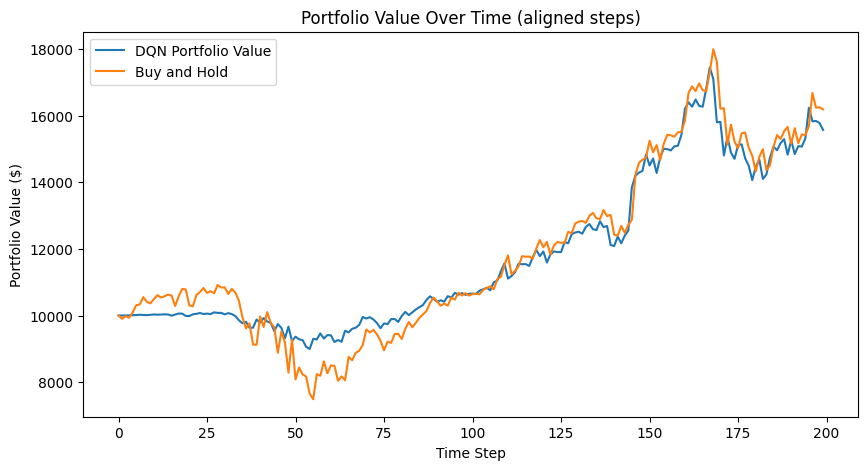

In [2]:
def fetch_data(symbol, start_date, end_date):
    df = yf.download(symbol, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    return df

# %%

def add_indicators(df, window_sma=10, window_ema=10, window_rsi=14):
    df['SMA'] = df['Close'].rolling(window=window_sma).mean()
    df['EMA'] = df['Close'].ewm(span=window_ema, adjust=False).mean()
    # RSI calculation
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=window_rsi).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window_rsi).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    #MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    # Sharpe
    log_returns = np.log(df['Close'] / df['Close'].shift(1))
    risk_free_rate=0.0
    excess= log_returns - risk_free_rate
    rolling_mean = excess.rolling(window=window_rsi).mean()
    rolling_std = excess.rolling(window=window_rsi).std()
    df['Sharpe'] = (rolling_mean / (rolling_std + 1e-8))
# New added features: MACD, MACD Signal, Sharpe

    # Back-fill NaN values
    df.bfill(inplace=True)
    return df


# %%
class TradingEnv(gym.Env):
    """Custom Gym environment for single-stock trading"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, initial_balance=10000, max_steps=200):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.max_steps = min(max_steps, len(df) - 1)

        # Actions: 0 = hold, 1 = buy 1 share, 2 = sell 1 share
        self.action_space = spaces.Discrete(3)
        # Observation: [close, SMA, EMA, RSI, MACD, Singnal, Sharpe, holdings, cash]
        obs_low = np.array([0, 0, 0, 0, -np.inf, -np.inf, -np.inf, 0, 0], dtype=np.float32)
        obs_high = np.array([np.inf, np.inf, np.inf, 100, np.inf, np.inf, np.inf, np.inf, np.inf], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)

    def reset(self):
        self.balance = float(self.initial_balance)
        self.net_worth = float(self.initial_balance)
        self.shares_held = 0
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.df.loc[self.current_step]
        return np.array([
            row['Close'].item(),
            row['SMA'].item(),
            row['EMA'].item(),
            row['RSI'].item(),
            row['MACD'].item(),
            row['Signal'].item(),
            row['Sharpe'].item(),
            float(self.shares_held),
            float(self.balance)
        ], dtype=np.float32)

    def step(self, action):
        row = self.df.loc[self.current_step]
        price = row['Close'].item()
        prev_net_worth = self.net_worth

        # Execute action
        if action == 1:  # buy
            if self.balance >= price:
                self.shares_held += 1
                self.balance -= price
        elif action == 2:  # sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += price

        self.current_step += 1
        done = self.current_step >= self.max_steps
        row_next = self.df.loc[self.current_step]
        self.net_worth = self.balance + self.shares_held * row_next['Close'].item()
        reward = self.net_worth - prev_net_worth

        obs = self._get_obs()
        return obs, reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}, Net Worth: {self.net_worth:.2f}")


# %%
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# %%
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)



# %%
# Hyperparameters
episode_count = 500
nb_steps = 200
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 500
batch_size = 64
target_update = 10

# Fetch and prepare data
df = fetch_data('AAPL', '2020-01-01', '2021-01-01')
df = add_indicators(df)

env = TradingEnv(df, initial_balance=10000, max_steps=200)

# Init networks and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
memory = ReplayBuffer()

steps_done = 0

def select_action(state):
    global steps_done
    eps_threshold = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * steps_done / epsilon_decay)
    steps_done += 1
    if random.random() < eps_threshold:
        return random.randrange(env.action_space.n)
    with torch.no_grad():
        state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = policy_net(state_v)
        return q_values.argmax().item()

for episode in range(1, episode_count + 1):
    state = env.reset()
    total_reward = 0
    for t in range(nb_steps):
        action = select_action(state)
        next_state, reward, done, _ = env.step(action)
        memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Learn from experience
        if len(memory) >= batch_size:
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32).to(device)
            action_batch = torch.tensor(batch.action).unsqueeze(1).to(device)
            reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
            next_state_batch = torch.tensor(np.array(batch.next_state), dtype=torch.float32).to(device)
            done_batch = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

            q_values = policy_net(state_batch).gather(1, action_batch)
            next_q_values = target_net(next_state_batch).max(1)[0].detach().unsqueeze(1)
            expected_q = reward_batch + (gamma * next_q_values * (1 - done_batch))

            loss = nn.MSELoss()(q_values, expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    print(f"Episode {episode}/{episode_count}, Total Reward: {total_reward:.2f}")



# %%
state = env.reset()
values = []
s = state
for _ in range(env.max_steps):
    action = policy_net(
        torch.tensor(s, dtype=torch.float32)
               .unsqueeze(0).to(device)
    ).argmax().item()
    s, _, done, _ = env.step(action)
    values.append(env.net_worth)
    if done:
        break

# Generate buy‑and‑hold values for the same number of steps:
bh_prices = df['Close'].iloc[:len(values)].values
bh_values  = bh_prices / bh_prices[0] * env.initial_balance

# Plot both on a shared 0–N axis:
plt.figure(figsize=(10, 5))
plt.plot(range(len(values)), values, label='DQN Portfolio Value')
plt.plot(range(len(bh_values)), bh_values, label='Buy and Hold')
plt.legend()
plt.title('Portfolio Value Over Time (aligned steps)')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value ($)')
plt.show()




# ## End of Notebook
# You can now experiment with parameters, different stocks, or add more indicators!

/tmp/ipython-input-2-103283232.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


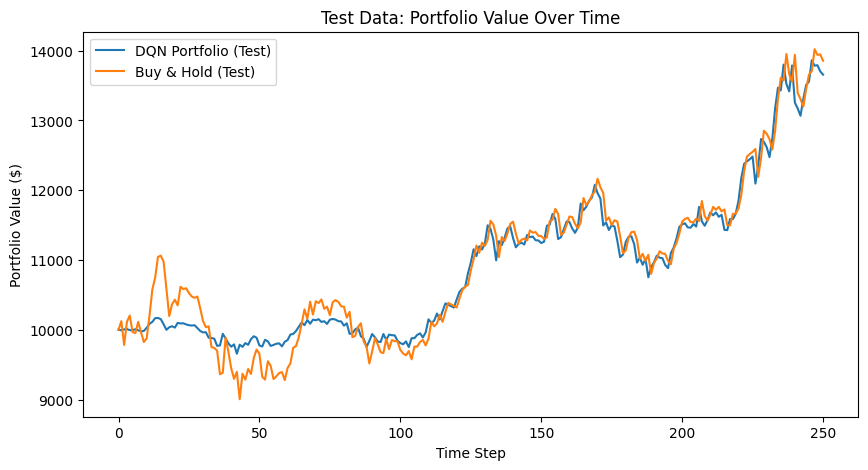

In [3]:
# Fetch and prepare unseen test data
df_test = fetch_data('AAPL', '2021-01-02', '2022-01-01')
df_test = add_indicators(df_test)
# Create new test environment
env_test = TradingEnv(df_test, initial_balance=10000, max_steps=len(df_test)-1)

# Run greedy policy on test environment
state = env_test.reset()
values_test = []
s = state
for _ in range(env_test.max_steps):
    action = policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
    s, _, done, _ = env_test.step(action)
    values_test.append(env_test.net_worth)
    if done:
        break

# Plot test performance
plt.figure(figsize=(10, 5))
plt.plot(range(len(values_test)), values_test, label='DQN Portfolio (Test)')
bh_test = df_test['Close'].iloc[:len(values_test)].values
bh_values_test = bh_test / bh_test[0] * env_test.initial_balance
plt.plot(range(len(bh_values_test)), bh_values_test, label='Buy & Hold (Test)')
plt.legend()
plt.title('Test Data: Portfolio Value Over Time')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value ($)')
plt.show()


                         
#                        Agent Action Over Time

Action counts on test run: Counter({1: 164, 2: 87})


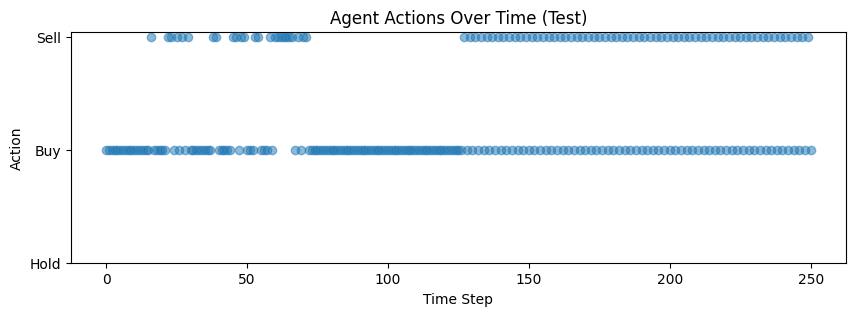

In [4]:
# ==== Record actions during your test roll‑out ====
actions = []
state = env_test.reset()
for _ in range(env_test.max_steps):
    # select greedy action
    action = policy_net(
        torch.tensor(state, dtype=torch.float32)
             .unsqueeze(0).to(device)
    ).argmax().item()
    actions.append(action)
    state, _, done, _ = env_test.step(action)
    if done:
        break

# ==== Print counts ====
from collections import Counter
counts = Counter(actions)
print("Action counts on test run:", counts)
# e.g. Counter({0: 150, 1: 25, 2: 25})

# ==== (Optional) Plot actions over time ====
plt.figure(figsize=(10,3))
plt.plot(actions, marker='o', linestyle='', alpha=0.5)
plt.yticks([0,1,2], ["Hold","Buy","Sell"])
plt.title("Agent Actions Over Time (Test)")
plt.xlabel("Time Step")
plt.ylabel("Action")
plt.show()


# This model is very conservative and holds which should be improved you should work upon that ignore all the code below


In [5]:
actions = []
state = env_test.reset()
for _ in range(env_test.max_steps):
    action = policy_net(torch.tensor(state, dtype=torch.float32)
                        .unsqueeze(0).to(device)).argmax().item()
    actions.append(action)
    state, _, done, _ = env_test.step(action)
    if done: break

print("Action counts:", {a: actions.count(a) for a in set(actions)})


Action counts: {1: 164, 2: 87}


#Add a small penalty for each trade to discourage inaction‑only policies, or a bonus for correctly timed trades

/tmp/ipython-input-6-2164705861.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-6-2164705861.py:166: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  s_b = torch.tensor(batch.state, dtype=torch.float32).to(device)


Episode 1/300, Total Reward: 236.62
Episode 2/300, Total Reward: 104.12
Episode 3/300, Total Reward: 40.19
Episode 4/300, Total Reward: 233.08
Episode 5/300, Total Reward: 129.11
Episode 6/300, Total Reward: 93.68
Episode 7/300, Total Reward: -23.21
Episode 8/300, Total Reward: -35.69
Episode 9/300, Total Reward: 16.72
Episode 10/300, Total Reward: 41.67
Episode 11/300, Total Reward: 6.86
Episode 12/300, Total Reward: 5.32
Episode 13/300, Total Reward: 111.01
Episode 14/300, Total Reward: 17.40
Episode 15/300, Total Reward: 3.52
Episode 16/300, Total Reward: 73.33
Episode 17/300, Total Reward: 16.99
Episode 18/300, Total Reward: -164.90
Episode 19/300, Total Reward: 131.15
Episode 20/300, Total Reward: 51.25
Episode 21/300, Total Reward: 102.60
Episode 22/300, Total Reward: 76.30
Episode 23/300, Total Reward: 18.20
Episode 24/300, Total Reward: 73.04
Episode 25/300, Total Reward: 13.41
Episode 26/300, Total Reward: -9.23
Episode 27/300, Total Reward: 19.59
Episode 28/300, Total Reward:

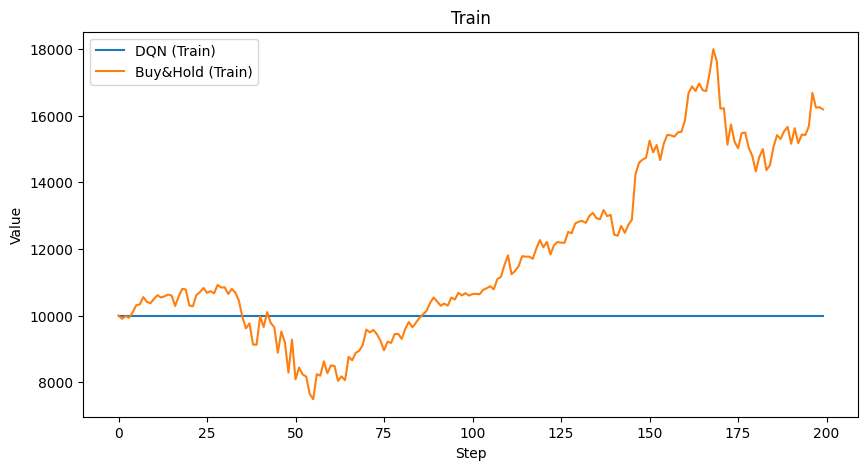

/tmp/ipython-input-6-2164705861.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


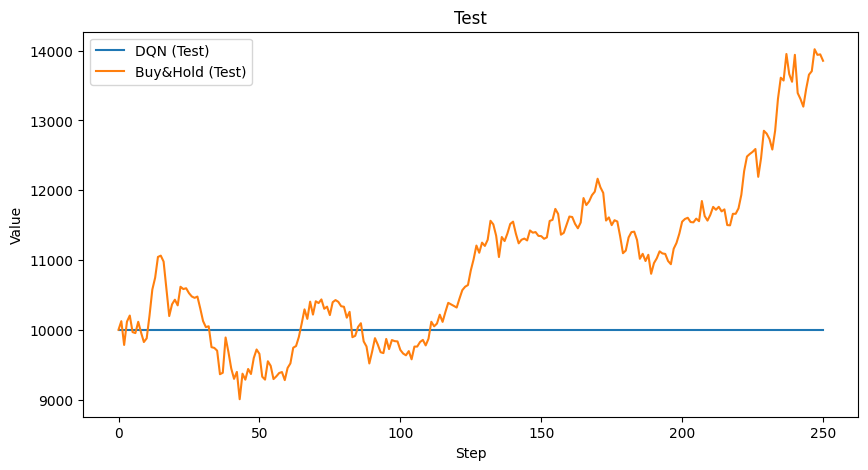

In [6]:

# ## 2. Data Fetching and Indicator Computation

# %%

def fetch_data(symbol, start_date, end_date):
    df = yf.download(symbol, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    return df

# %%

def add_indicators(df, window_sma=10, window_ema=10, window_rsi=14):
    df['SMA'] = df['Close'].rolling(window=window_sma).mean()
    df['EMA'] = df['Close'].ewm(span=window_ema, adjust=False).mean()
    # RSI calculation
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=window_rsi).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window_rsi).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df.bfill(inplace=True)
    return df

# ## 3. Define Trading Environment with Reward Shaping

# %%
class TradingEnv(gym.Env):
    """Custom Gym environment for single-stock trading with trade penalty"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, initial_balance=10000, max_steps=200, trade_penalty=0.1):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.max_steps = min(max_steps, len(df) - 1)
        self.trade_penalty = trade_penalty

        # Actions: 0 = hold, 1 = buy 1 share, 2 = sell 1 share
        self.action_space = spaces.Discrete(3)
        # Observation: [close, SMA, EMA, RSI, holdings, cash]
        obs_low = np.array([0, 0, 0, 0, 0, 0], dtype=np.float32)
        obs_high= np.array([np.inf, np.inf, np.inf, 100, np.inf, np.inf], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)

    def reset(self):
        self.balance = float(self.initial_balance)
        self.net_worth = float(self.initial_balance)
        self.shares_held = 0
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.df.loc[self.current_step]
        return np.array([
            row['Close'].item(), row['SMA'].item(), row['EMA'].item(), row['RSI'].item(),
            float(self.shares_held), float(self.balance)
        ], dtype=np.float32)

    def step(self, action):
        row = self.df.loc[self.current_step]
        price = row['Close'].item()
        prev_net_worth = self.net_worth

        # Execute action
        trade_cost = 0.0
        if action == 1 and self.balance >= price:
            self.shares_held += 1
            self.balance -= price
            trade_cost = self.trade_penalty
        elif action == 2 and self.shares_held > 0:
            self.shares_held -= 1
            self.balance += price
            trade_cost = self.trade_penalty

        self.current_step += 1
        done = self.current_step >= self.max_steps
        row_next = self.df.loc[self.current_step]
        self.net_worth = self.balance + self.shares_held * row_next['Close'].item()

        # Reward = change in net worth minus trade penalty
        reward = (self.net_worth - prev_net_worth) - trade_cost

        obs = self._get_obs()
        return obs, reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}, Net Worth: {self.net_worth:.2f}")


# ## 4. Define DQN Agent

# %%
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# %%
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)
    def push(self, *args): self.memory.append(Transition(*args))
    def sample(self, batch_size): return random.sample(self.memory, batch_size)
    def __len__(self): return len(self.memory)


# ## 5. Training Loop

# %%
# Hyperparameters
episode_count = 300
nb_steps = 200
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 500
batch_size = 64
target_update = 10

# Fetch and prepare data
df = fetch_data('AAPL', '2020-01-01', '2021-01-01')
df = add_indicators(df)

# Use reward shaping penalty=0.1
env = TradingEnv(df, initial_balance=10000, max_steps=200, trade_penalty=0.1)

# Init networks and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
memory = ReplayBuffer()
steps_done = 0

def select_action(state):
    global steps_done
    eps = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * steps_done / epsilon_decay)
    steps_done += 1
    if random.random() < eps:
        return random.randrange(env.action_space.n)
    with torch.no_grad():
        state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        return policy_net(state_v).argmax().item()

for episode in range(1, episode_count + 1):
    state = env.reset()
    total_reward = 0
    for t in range(nb_steps):
        action = select_action(state)
        next_state, reward, done, _ = env.step(action)
        memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if len(memory) >= batch_size:
            batch = Transition(*zip(*random.sample(memory.memory, batch_size)))
            s_b = torch.tensor(batch.state, dtype=torch.float32).to(device)
            a_b = torch.tensor(batch.action).unsqueeze(1).to(device)
            r_b = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
            ns_b= torch.tensor(batch.next_state, dtype=torch.float32).to(device)
            d_b = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)
            q = policy_net(s_b).gather(1, a_b)
            qn= target_net(ns_b).max(1)[0].detach().unsqueeze(1)
            y = r_b + gamma * qn * (1 - d_b)
            loss = nn.MSELoss()(q, y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        if done: break
    if episode % target_update == 0: target_net.load_state_dict(policy_net.state_dict())
    print(f"Episode {episode}/{episode_count}, Total Reward: {total_reward:.2f}")


# ## 6. Evaluation on Training Data

# %%
state = env.reset(); values = []; s = state
for _ in range(env.max_steps):
    a = policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
    s, _, done, _ = env.step(a); values.append(env.net_worth)
    if done: break
plt.figure(figsize=(10,5))
plt.plot(range(len(values)), values, label='DQN (Train)')
bh = df['Close'].iloc[:len(values)].values; bhv = bh/bh[0]*env.initial_balance
plt.plot(range(len(bhv)), bhv, label='Buy&Hold (Train)'); plt.legend(); plt.title('Train'); plt.xlabel('Step'); plt.ylabel('Value'); plt.show()


# ## 7. Evaluation on Test Data

# %%
df_test = fetch_data('AAPL', '2021-01-02', '2022-01-01'); df_test = add_indicators(df_test)
env_test = TradingEnv(df_test, initial_balance=10000, max_steps=len(df_test)-1, trade_penalty=0.1)
state = env_test.reset(); values_test = []; s = state
for _ in range(env_test.max_steps):
    a = policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
    s, _, done, _ = env_test.step(a); values_test.append(env_test.net_worth)
    if done: break
plt.figure(figsize=(10,5))
plt.plot(range(len(values_test)), values_test, label='DQN (Test)')
bht = df_test['Close'].iloc[:len(values_test)].values; bhtv = bht/bht[0]*env_test.initial_balance
plt.plot(range(len(bhtv)), bhtv, label='Buy&Hold (Test)'); plt.legend(); plt.title('Test'); plt.xlabel('Step'); plt.ylabel('Value'); plt.show()


/tmp/ipython-input-7-265515970.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Episode 1/500, Total Reward: 439.83
Episode 2/500, Total Reward: 164.86
Episode 3/500, Total Reward: 774.53
Episode 4/500, Total Reward: 20.38
Episode 5/500, Total Reward: 172.95
Episode 6/500, Total Reward: 25.99
Episode 7/500, Total Reward: 55.83
Episode 8/500, Total Reward: 625.54
Episode 9/500, Total Reward: 24.23
Episode 10/500, Total Reward: 226.51
Episode 11/500, Total Reward: 658.57
Episode 12/500, Total Reward: 351.17
Episode 13/500, Total Reward: 393.51
Episode 14/500, Total Reward: 160.51
Episode 15/500, Total Reward: 207.28
Episode 16/500, Total Reward: 110.81
Episode 17/500, Total Reward: 596.61
Episode 18/500, Total Reward: 344.83
Episode 19/500, Total Reward: 625.33
Episode 20/500, Total Reward: 805.76
Episode 21/500, Total Reward: 481.94
Episode 22/500, Total Reward: 1073.77
Episode 23/500, Total Reward: 1361.79
Episode 24/500, Total Reward: 566.54
Episode 25/500, Total Reward: 555.83
Episode 26/500, Total Reward: 567.82
Episode 27/500, Total Reward: 555.68
Episode 28/5

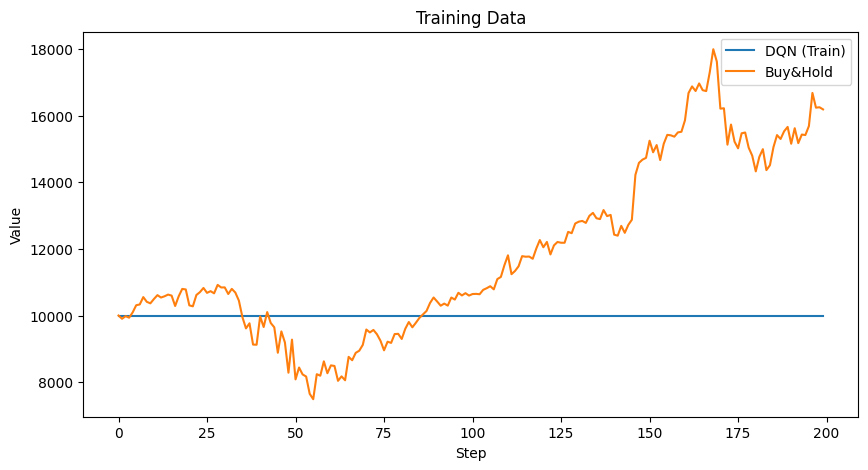

In [7]:



# ## 2. Data Fetching and Indicator Computation (with extra features)

# %%

def fetch_data(symbol, start_date, end_date):
    df = yf.download(symbol, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    return df

# %%

def add_indicators(df, window_sma=10, window_ema=10, window_rsi=14):
    # Moving averages and RSI
    df['SMA'] = df['Close'].rolling(window=window_sma).mean()
    df['EMA'] = df['Close'].ewm(span=window_ema, adjust=False).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=window_rsi).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window_rsi).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    # Momentum features: 1-day and 5-day returns
    df['Ret1'] = df['Close'].pct_change(1)
    df['Ret5'] = df['Close'].pct_change(5)
    # Volume feature: 5-day average volume
    df['VolAvg'] = df['Volume'].rolling(window=5).mean()
    df.bfill(inplace=True)
    return df


# ## 3. Define Trading Environment with Reward Shaping

# %%
class TradingEnv(gym.Env):
    """Custom Gym environment with momentum & volume features and bonuses for correctly timed trades"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, initial_balance=10000, max_steps=200, bonus=0.1):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.max_steps = min(max_steps, len(df) - 1)
        self.bonus = bonus

        # Actions: 0 = hold, 1 = buy, 2 = sell
        self.action_space = spaces.Discrete(3)
        # Observation: [Close, SMA, EMA, RSI, Ret1, Ret5, VolAvg, holdings, cash]
        obs_low = np.array([0, 0, 0, 0, -1, -1, 0, 0, 0], dtype=np.float32)
        obs_high= np.array([np.inf, np.inf, np.inf, 100, 1, 1, np.inf, np.inf, np.inf], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)

    def reset(self):
        self.balance = float(self.initial_balance)
        self.net_worth = float(self.initial_balance)
        self.shares_held = 0
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.df.loc[self.current_step]
        return np.array([
            row['Close'].item(), row['SMA'].item(), row['EMA'].item(), row['RSI'].item(),
            row['Ret1'].item(), row['Ret5'].item(), row['VolAvg'].item(),
            float(self.shares_held), float(self.balance)
        ], dtype=np.float32)

    def step(self, action):
        row = self.df.loc[self.current_step]
        price = row['Close'].item()
        prev_net_worth = self.net_worth

        # Execute action
        if action == 1 and self.balance >= price:
            self.shares_held += 1
            self.balance -= price
        elif action == 2 and self.shares_held > 0:
            self.shares_held -= 1
            self.balance += price

        self.current_step += 1
        done = self.current_step >= self.max_steps
        next_row = self.df.loc[self.current_step]
        self.net_worth = self.balance + self.shares_held * next_row['Close'].item()

        # Base reward = net worth change
        reward = self.net_worth - prev_net_worth
        # Bonus for correctly timed trades
        if action == 1 and next_row['Close'].item() > price:
            reward += self.bonus
        if action == 2 and next_row['Close'].item() < price:
            reward += self.bonus

        return self._get_obs(), reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}, Net Worth: {self.net_worth:.2f}")


# ## 4. Define DQN Agent

# %%
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayBuffer:
    def __init__(self, capacity=10000): self.memory = deque(maxlen=capacity)
    def push(self, *args): self.memory.append(Transition(*args))
    def sample(self, bs): return random.sample(self.memory, bs)
    def __len__(self): return len(self.memory)


# ## 5. Training Loop

# %%
episode_count=500; nb_steps=200; gamma=0.99
epsilon_start=1.0; epsilon_end=0.05; epsilon_decay=2000
batch_size=64; target_update=10

# Fetch and prepare training data
df = fetch_data('AAPL','2020-01-01','2021-01-01')
df = add_indicators(df)
env = TradingEnv(df, bonus=0.1)

# Initialize DQN networks and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict()); target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
memory = ReplayBuffer()
steps_done = 0

def select_action(state):
    global steps_done
    eps = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * steps_done / epsilon_decay)
    steps_done += 1
    if random.random() < eps:
        return random.randrange(env.action_space.n)
    with torch.no_grad():
        return policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()

for ep in range(1, episode_count+1):
    state = env.reset(); total_reward = 0
    for t in range(nb_steps):
        action = select_action(state)
        next_state, reward, done, _ = env.step(action)
        memory.push(state, action, reward, next_state, done)
        state = next_state; total_reward += reward
        if len(memory) >= batch_size:
            batch = Transition(*zip(*memory.sample(batch_size)))
            s_b = torch.tensor(batch.state, dtype=torch.float32).to(device)
            a_b = torch.tensor(batch.action).unsqueeze(1).to(device)
            r_b = torch.tensor(batch.reward).unsqueeze(1).to(device)
            ns_b= torch.tensor(batch.next_state, dtype=torch.float32).to(device)
            d_b = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)
            q = policy_net(s_b).gather(1, a_b)
            qn= target_net(ns_b).max(1)[0].detach().unsqueeze(1)
            y = r_b + gamma * qn * (1.0 - d_b)
            loss = nn.MSELoss()(q, y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        if done: break
    if ep % target_update == 0: target_net.load_state_dict(policy_net.state_dict())
    print(f"Episode {ep}/{episode_count}, Total Reward: {total_reward:.2f}")


# ## 6. Evaluation on Training Data

# %%
state = env.reset(); vals = []
s = state
for _ in range(env.max_steps):
    a = policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
    s, _, done, _ = env.step(a); vals.append(env.net_worth)
    if done: break
plt.figure(figsize=(10,5))
plt.plot(range(len(vals)), vals, label='DQN (Train)')
bh = df['Close'].iloc[:len(vals)].values; bhv = bh/bh[0]*env.initial_balance
plt.plot(range(len(bhv)), bhv, label='Buy&Hold'); plt.legend(); plt.title('Training Data'); plt.xlabel('Step'); plt.ylabel('Value'); plt.show()





/tmp/ipython-input-7-265515970.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


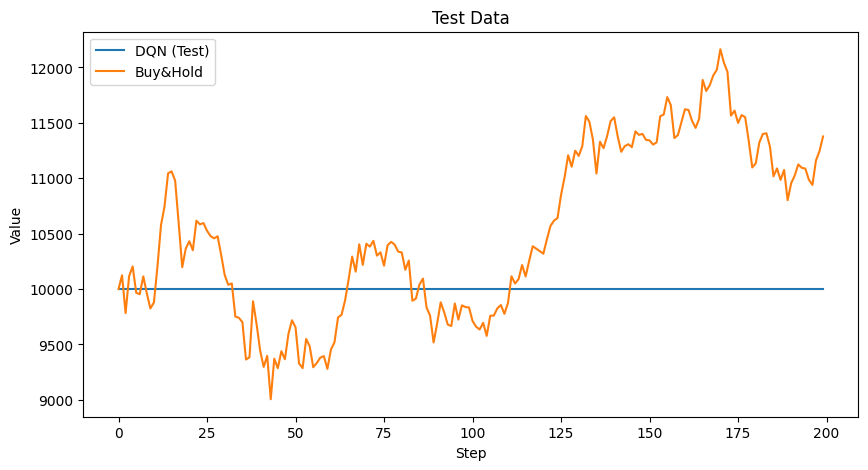

In [8]:
# ## 7. Evaluation on Test Data

# %%
df_test = fetch_data('AAPL','2021-01-02','2023-01-01'); df_test = add_indicators(df_test)
env_test = TradingEnv(df_test, bonus=0.1)
state = env_test.reset(); vals_test = []
s = state
for _ in range(env_test.max_steps):
    a = policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
    s, _, done, _ = env_test.step(a); vals_test.append(env_test.net_worth)
    if done: break
plt.figure(figsize=(10,5))
plt.plot(range(len(vals_test)), vals_test, label='DQN (Test)')
bh = df_test['Close'].iloc[:len(vals_test)].values; bhv = bh/bh[0]*env_test.initial_balance
plt.plot(range(len(bhv)), bhv, label='Buy&Hold'); plt.legend(); plt.title('Test Data'); plt.xlabel('Step'); plt.ylabel('Value'); plt.show()

Action counts on test run: Counter({2: 200})


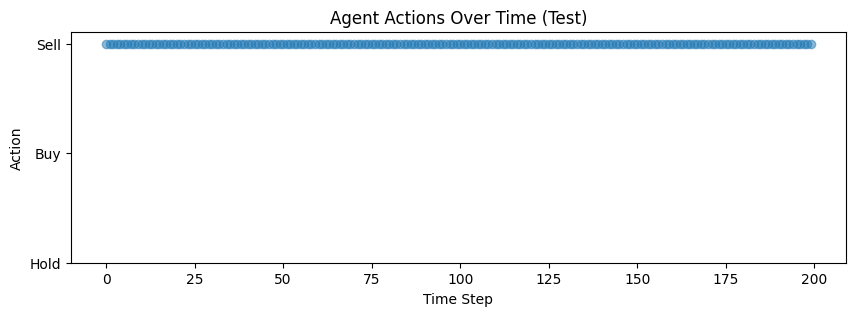

In [9]:
# ==== Record actions during your test roll‑out ====
actions = []
state = env_test.reset()
for _ in range(env_test.max_steps):
    # select greedy action
    action = policy_net(
        torch.tensor(state, dtype=torch.float32)
             .unsqueeze(0).to(device)
    ).argmax().item()
    actions.append(action)
    state, _, done, _ = env_test.step(action)
    if done:
        break

# ==== Print counts ====
from collections import Counter
counts = Counter(actions)
print("Action counts on test run:", counts)
# e.g. Counter({0: 150, 1: 25, 2: 25})

# ==== (Optional) Plot actions over time ====
plt.figure(figsize=(10,3))
plt.plot(actions, marker='o', linestyle='', alpha=0.5)
plt.yticks([0,1,2], ["Hold","Buy","Sell"])
plt.title("Agent Actions Over Time (Test)")
plt.xlabel("Time Step")
plt.ylabel("Action")
plt.show()


/tmp/ipython-input-10-2076723982.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Episode 1/500, Total Reward: 82.15
Episode 2/500, Total Reward: 263.33
Episode 3/500, Total Reward: 131.68
Episode 4/500, Total Reward: 285.30
Episode 5/500, Total Reward: 59.02
Episode 6/500, Total Reward: 109.42
Episode 7/500, Total Reward: 263.71
Episode 8/500, Total Reward: 59.29
Episode 9/500, Total Reward: 26.39
Episode 10/500, Total Reward: 234.52
Episode 11/500, Total Reward: 269.09
Episode 12/500, Total Reward: 194.67
Episode 13/500, Total Reward: 680.23
Episode 14/500, Total Reward: 679.89
Episode 15/500, Total Reward: 381.89
Episode 16/500, Total Reward: 64.78
Episode 17/500, Total Reward: 107.17
Episode 18/500, Total Reward: -19.77
Episode 19/500, Total Reward: 325.60
Episode 20/500, Total Reward: 26.88
Episode 21/500, Total Reward: 81.61
Episode 22/500, Total Reward: 170.05
Episode 23/500, Total Reward: -18.01
Episode 24/500, Total Reward: 39.36
Episode 25/500, Total Reward: 348.04
Episode 26/500, Total Reward: 627.73
Episode 27/500, Total Reward: 220.80
Episode 28/500, To

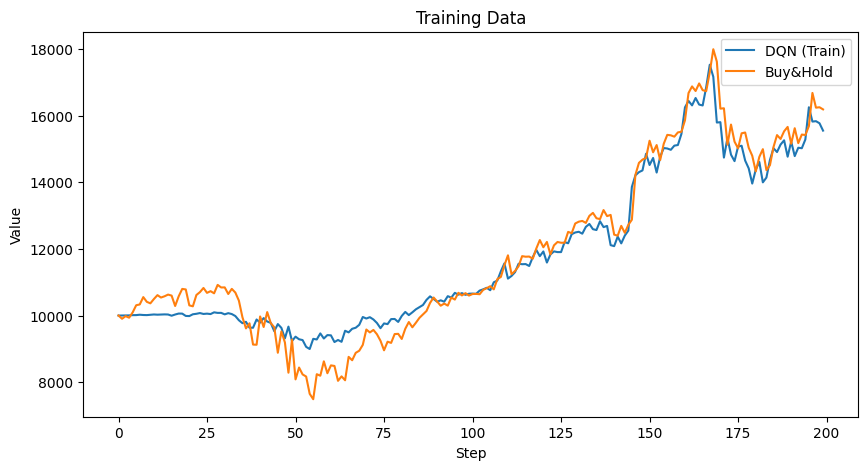

/tmp/ipython-input-10-2076723982.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


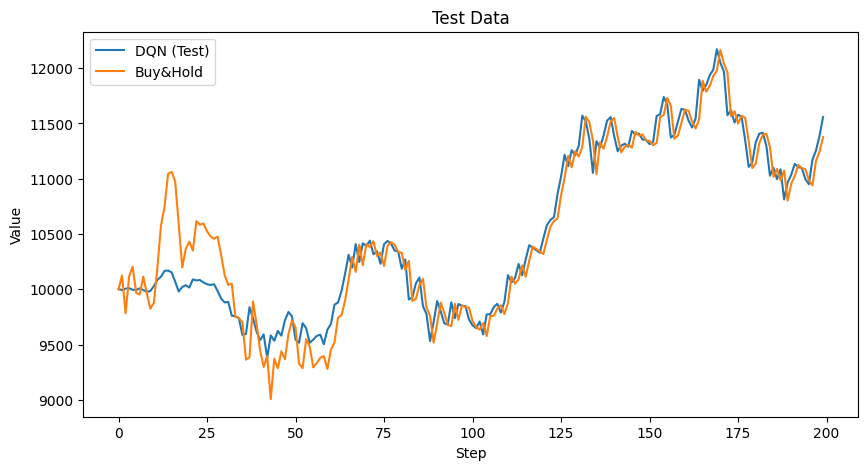

In [10]:

# ## 2. Data Fetching and Indicator Computation (with extra features)

# %%

def fetch_data(symbol, start_date, end_date):
    df = yf.download(symbol, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    return df

# %%

def add_indicators(df, window_sma=10, window_ema=10, window_rsi=14):
    # Moving averages and RSI
    df['SMA'] = df['Close'].rolling(window=window_sma).mean()
    df['EMA'] = df['Close'].ewm(span=window_ema, adjust=False).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=window_rsi).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window_rsi).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    # Momentum features: 1-day and 5-day returns
    df['Ret1'] = df['Close'].pct_change(1)
    df['Ret5'] = df['Close'].pct_change(5)
    # Volume feature: 5-day average volume
    df['VolAvg'] = df['Volume'].rolling(window=5).mean()
    df.bfill(inplace=True)
    return df


# ## 3. Define Trading Environment with Reward Shaping and Trade Penalty

# %%
class TradingEnv(gym.Env):
    """Custom Gym environment with momentum & volume features, bonuses, and penalties"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, initial_balance=10000, max_steps=200, bonus=0.1, trade_penalty=0.1):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.max_steps = min(max_steps, len(df) - 1)
        self.bonus = bonus
        self.trade_penalty = trade_penalty

        # Actions: 0 = hold, 1 = buy, 2 = sell
        self.action_space = spaces.Discrete(3)
        # Observation: [Close, SMA, EMA, RSI, Ret1, Ret5, VolAvg, holdings, cash]
        obs_low = np.array([0, 0, 0, 0, -1, -1, 0, 0, 0], dtype=np.float32)
        obs_high= np.array([np.inf, np.inf, np.inf, 100, 1, 1, np.inf, np.inf, np.inf], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)

    def reset(self):
        self.balance = float(self.initial_balance)
        self.net_worth = float(self.initial_balance)
        self.shares_held = 0
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.df.loc[self.current_step]
        return np.array([
            row['Close'].item(), row['SMA'].item(), row['EMA'].item(), row['RSI'].item(),
            row['Ret1'].item(), row['Ret5'].item(), row['VolAvg'].item(),
            float(self.shares_held), float(self.balance)
        ], dtype=np.float32)

    def step(self, action):
        row = self.df.loc[self.current_step]
        price = row['Close'].item()
        prev_net_worth = self.net_worth

        # Execute action
        trade_cost = 0.0
        if action == 1 and self.balance >= price:
            self.shares_held += 1
            self.balance -= price
            trade_cost += self.trade_penalty
        elif action == 2 and self.shares_held > 0:
            self.shares_held -= 1
            self.balance += price
            trade_cost += self.trade_penalty

        # Advance step
        self.current_step += 1
        done = self.current_step >= self.max_steps
        next_row = self.df.loc[self.current_step]
        self.net_worth = self.balance + self.shares_held * next_row['Close'].item()

        # Base reward + bonuses
        reward = self.net_worth - prev_net_worth
        # Bonus for successfully timed trades
        if action == 1 and next_row['Close'].item() > price:
            reward += self.bonus
        if action == 2 and next_row['Close'].item() < price:
            reward += self.bonus
        # Subtract trade penalty
        reward -= trade_cost

        return self._get_obs(), reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}, Net Worth: {self.net_worth:.2f}")

## 4. Define DQN Agent Define DQN Agent

# %%
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayBuffer:
    def __init__(self, capacity=10000): self.memory = deque(maxlen=capacity)
    def push(self, *args): self.memory.append(Transition(*args))
    def sample(self, bs): return random.sample(self.memory, bs)
    def __len__(self): return len(self.memory)


# ## 5. Training Loop

# %%
episode_count=500; nb_steps=200; gamma=0.99
epsilon_start=1.0; epsilon_end=0.05; epsilon_decay=2000
batch_size=64; target_update=10

# Fetch and prepare training data
df = fetch_data('AAPL','2020-01-01','2021-01-01')
df = add_indicators(df)
env = TradingEnv(df, bonus=0.1)

# Initialize DQN networks and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict()); target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
memory = ReplayBuffer()
steps_done = 0

def select_action(state):
    global steps_done
    eps = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * steps_done / epsilon_decay)
    steps_done += 1
    if random.random() < eps:
        return random.randrange(env.action_space.n)
    with torch.no_grad():
        return policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()

for ep in range(1, episode_count+1):
    state = env.reset(); total_reward = 0
    for t in range(nb_steps):
        action = select_action(state)
        next_state, reward, done, _ = env.step(action)
        memory.push(state, action, reward, next_state, done)
        state = next_state; total_reward += reward
        if len(memory) >= batch_size:
            batch = Transition(*zip(*memory.sample(batch_size)))
            s_b = torch.tensor(batch.state, dtype=torch.float32).to(device)
            a_b = torch.tensor(batch.action).unsqueeze(1).to(device)
            r_b = torch.tensor(batch.reward).unsqueeze(1).to(device)
            ns_b= torch.tensor(batch.next_state, dtype=torch.float32).to(device)
            d_b = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)
            q = policy_net(s_b).gather(1, a_b)
            qn= target_net(ns_b).max(1)[0].detach().unsqueeze(1)
            y = r_b + gamma * qn * (1.0 - d_b)
            loss = nn.MSELoss()(q, y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        if done: break
    if ep % target_update == 0: target_net.load_state_dict(policy_net.state_dict())
    print(f"Episode {ep}/{episode_count}, Total Reward: {total_reward:.2f}")


# ## 6. Evaluation on Training Data

# %%
state = env.reset(); vals = []
s = state
for _ in range(env.max_steps):
    a = policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
    s, _, done, _ = env.step(a); vals.append(env.net_worth)
    if done: break
plt.figure(figsize=(10,5))
plt.plot(range(len(vals)), vals, label='DQN (Train)')
bh = df['Close'].iloc[:len(vals)].values; bhv = bh/bh[0]*env.initial_balance
plt.plot(range(len(bhv)), bhv, label='Buy&Hold'); plt.legend(); plt.title('Training Data'); plt.xlabel('Step'); plt.ylabel('Value'); plt.show()


# ## 7. Evaluation on Test Data

# %%
df_test = fetch_data('AAPL','2021-01-02','2022-01-01'); df_test = add_indicators(df_test)
env_test = TradingEnv(df_test, bonus=0.1)
state = env_test.reset(); vals_test = []
s = state
for _ in range(env_test.max_steps):
    a = policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
    s, _, done, _ = env_test.step(a); vals_test.append(env_test.net_worth)
    if done: break
plt.figure(figsize=(10,5))
plt.plot(range(len(vals_test)), vals_test, label='DQN (Test)')
bh = df_test['Close'].iloc[:len(vals_test)].values; bhv = bh/bh[0]*env_test.initial_balance
plt.plot(range(len(bhv)), bhv, label='Buy&Hold'); plt.legend(); plt.title('Test Data'); plt.xlabel('Step'); plt.ylabel('Value'); plt.show()


Action counts on test run: Counter({1: 200})


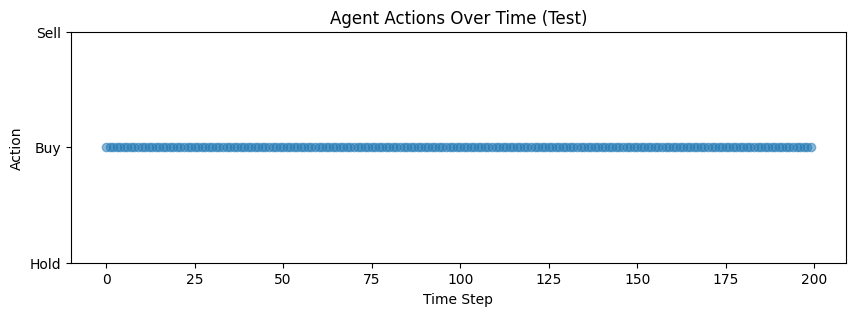

In [11]:
# ==== Record actions during your test roll‑out ====
actions = []
state = env_test.reset()
for _ in range(env_test.max_steps):
    # select greedy action
    action = policy_net(
        torch.tensor(state, dtype=torch.float32)
             .unsqueeze(0).to(device)
    ).argmax().item()
    actions.append(action)
    state, _, done, _ = env_test.step(action)
    if done:
        break

# ==== Print counts ====
from collections import Counter
counts = Counter(actions)
print("Action counts on test run:", counts)
# e.g. Counter({0: 150, 1: 25, 2: 25})

# ==== (Optional) Plot actions over time ====
plt.figure(figsize=(10,3))
plt.plot(actions, marker='o', linestyle='', alpha=0.5)
plt.yticks([0,1,2], ["Hold","Buy","Sell"])
plt.title("Agent Actions Over Time (Test)")
plt.xlabel("Time Step")
plt.ylabel("Action")
plt.show()
